# **Footbal Manager Current Ability(CA) prediction**

Import necessari. Opendatasets per l'import automatico del dataset da kaggle.
Link dataset: https://www.kaggle.com/datasets/gabrielabilleira/football-manager-2022-player-data
 

In [ ]:
!pip install opendatasets
!pip install category_encoders

In [45]:
import sklearn as sk
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import xgboost as xg

from category_encoders import MEstimateEncoder

import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

First things first, carico il dataset. Non essendo una competizione kaggle, ma un dataset amatoriale, non ci saranno i soliti due split "train-test", ma un solo grosso dataset. Dopo userò la routine di skleanr "train_test_split" in modo da creare due dataset distinti e randomicamente separati da usare.

In [3]:
od.download("https://www.kaggle.com/datasets/gabrielabilleira/football-manager-2022-player-data/variables.csv")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: marianocaccavale
Your Kaggle Key: ··········


100%|██████████| 93.5k/93.5k [00:00<00:00, 34.1MB/s]

In [4]:
dataset_link = "./football-manager-2022-player-data/variables.csv"

dataset = pd.read_csv(dataset_link, index_col = "Unnamed: 0")

In [5]:
dataset

,Name,Apps,Mins,Mins/Gm,Height,Weight,Age,Av Rat,Gls,Gls/90,...,Off,Based,Tck R,CA,Saves,Saves/xSv%,Gls/xG,Dist/Mins,Transfer Value,Value
0,Josip Mijatović,12.0,809.0,67.416667,173.0,68.0,20,7.14,1.0,0.11,...,0.0,Croatia (3. HNL Zapad),0.88,84,0.0,0.000000,5.555556,0.126823,€3K - €9K,6000.0
1,Duje Ninčević,15.0,1161.0,77.400000,172.0,69.0,25,6.84,0.0,0.00,...,0.0,Croatia (3. HNL Jug),0.76,79,0.0,0.000000,0.000000,0.129457,€0 - €2.5K,1250.0
2,Marin Karabatić,15.0,1350.0,90.000000,170.0,62.0,22,6.90,0.0,0.00,...,0.0,Croatia (3. HNL Jug),0.77,87,0.0,0.000000,0.000000,0.128000,€0 - €12K,6000.0
3,Vicko Ševelj,20.0,1738.0,86.900000,192.0,86.0,22,7.15,1.0,0.05,...,1.0,Bosnia & Herzegovina (Liga 12),0.88,95,0.0,0.000000,2.380952,0.058631,€100K - €1M,550000.0
4,Fran Vujnović,15.0,1384.0,92.266667,190.0,77.0,19,7.23,4.0,0.26,...,0.0,Croatia (3. HNL Istok),0.93,83,0.0,0.000000,0.000000,0.016040,€14K - €150K,82000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1117,Sergio Ramos,11.0,924.0,84.000000,184.0,82.0,36,7.15,0.0,0.00,...,0.0,France (Ligue 1),0.74,156,0.0,0.000000,0.000000,0.123268,€12M - €18M,15000000.0
1118,Marquinhos,13.0,1129.0,86.846154,183.0,75.0,28,7.33,1.0,0.08,...,1.0,France (Ligue 1),1.00,163,0.0,0.000000,3.448276,0.126749,€99M - €128M,113500000.0
1119,Thibaut Courtois,19.0,1710.0,90.000000,199.0,96.0,30,7.42,0.0,0.00,...,0.0,Spain (LaLiga),0.33,180,48.0,-0.848956,0.000000,0.072982,€172M - €225M,198500000.0
1120,Raphaël Varane,17.0,1463.0,86.058824,191.0,81.0,29,7.36,0.0,0.00,...,2.0,England (Premier League),0.81,164,0.0,0.000000,0.000000,0.107792,€101M - €127M,114000000.0


Essendo un dataset unico, posso fare tutte le trasformazioni di pulizia qui, per poi spezzarlo in train e test con sklearn. Per prima cosa però, cerco di capire su cosa sto lavorando, in quanto non c'è nessun dato esterno al dataset che chiarisca eventuali colonne e i loro significati.

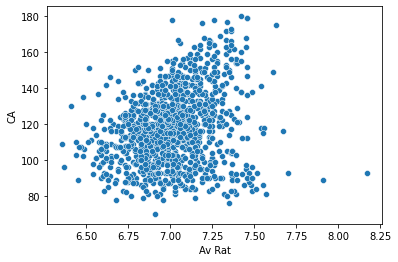

In [6]:
sns.scatterplot(x = "Av Rat", y = "CA", data = dataset)

Un preprocess che devo fare qui è quello del target encoding sulla feature "Based". Non posso farne un "one-hot encode" dato che ci sono
decisamente troppi valori unici e devo fare l'encode su tutti i dati per non sfasare train/test sets

In [ ]:
X = dataset.copy()
y = X.pop("CA")

encoder = MEstimateEncoder(cols = ["Based"], m = 5.0)

encoder.fit(X, y)
X = encoder.transform(X)

Ora divido il dataset in due(train e test) e inizio la feature engineering e preprocessing.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75)

Trasformo delle feature problematiche.

In [8]:
for col in X_train.columns:
  if X_train[col].dtype != "int64" and X_train[col].dtype != "float64":
    print(col)

Name
Transfer Value


In [ ]:
X_train.pop("Name")

X[["MinValueTrns", "MaxValueTrns"]] = (X["Transfer Value"].str.split(" - ", expand = True))
X.pop("Transfer Value")

Per esempio, il range di valori di vendita lo spezzo in due valori separati(prezzo massimo, prezzo minimo), e normalizzo la stringa trasformandola nel suo corrispettivo numerico(è ancora stringa, ma verrà trasformato in un numero dopo)

In [38]:
def encodeTransferValue(X, print = False):
  X["MinValueTrns"] = X["MinValueTrns"].str.replace("€", "")
  X["MaxValueTrns"] = X["MaxValueTrns"].str.replace("€", "")

  X["MinValueTrns"] = X["MinValueTrns"].str.replace("M", "000000")
  X["MaxValueTrns"] = X["MaxValueTrns"].str.replace("M", "000000")

  X["MinValueTrns"] = X["MinValueTrns"].str.replace("K", "000")
  X["MaxValueTrns"] = X["MaxValueTrns"].str.replace("K", "000")

  X["MinValueTrns"] = X["MinValueTrns"].str.replace(".", "")
  X["MaxValueTrns"] = X["MaxValueTrns"].str.replace(".", "")

  X["MinValueTrns"] = X["MinValueTrns"].astype("float64")
  X["MaxValueTrns"] = X["MaxValueTrns"].astype("float64")

  if print:
    print(X["MinValueTrns"])
    print(X["MaxValueTrns"])
  
  return X

In [ ]:
X_train = encodeTransferValue(X_train)

In [11]:
def fillNaN(X):
  X_tmp = X.copy()
  for col in X_tmp.columns:
    if X_tmp[col].isnull().any():
      if X_tmp[col].dtype == "int64" or X_tmp[col].dtype == "float64":
        X_tmp[col] = X_tmp[col].fillna(X_tmp[col].mean())
      else:
        X_tmp[col] = X_tmp[col].fillna(X_tmp[col].mode()[0])
  return X_tmp

Mi calcolo l'informazione mutuale tra le varie feature e la variabile target.

In [13]:
def calc_mi_scores(X, y, discrete_feature):
  mi_scores = mutual_info_regression(X, y, discrete_features = discrete_feature)
  mi_scores = pd.Series(data = mi_scores, index = X.columns, name = "MI scores")
  mi_scores = mi_scores.sort_values(ascending = False)
  return mi_scores 

In [14]:
def plot_mi_scores(scores):
  scores = scores.sort_values(ascending = True)
  width = np.arange(len(scores))
  ticks = list(scores.index)
  plt.barh(width, scores)
  plt.yticks(width, ticks)
  plt.title("Mutual Information Scores")

In [15]:
for colname in X_train.select_dtypes("category"):
  X_train[colname] = X_train[colname].factorize()

discrete_feature = X_train.dtypes == int

#print(discrete_feature.shape)

X_train = fillNaN(X_train)

#print(X_train.shape)
#print(y_train.shape)

mi_scores = calc_mi_scores(X_train, y_train, discrete_feature)

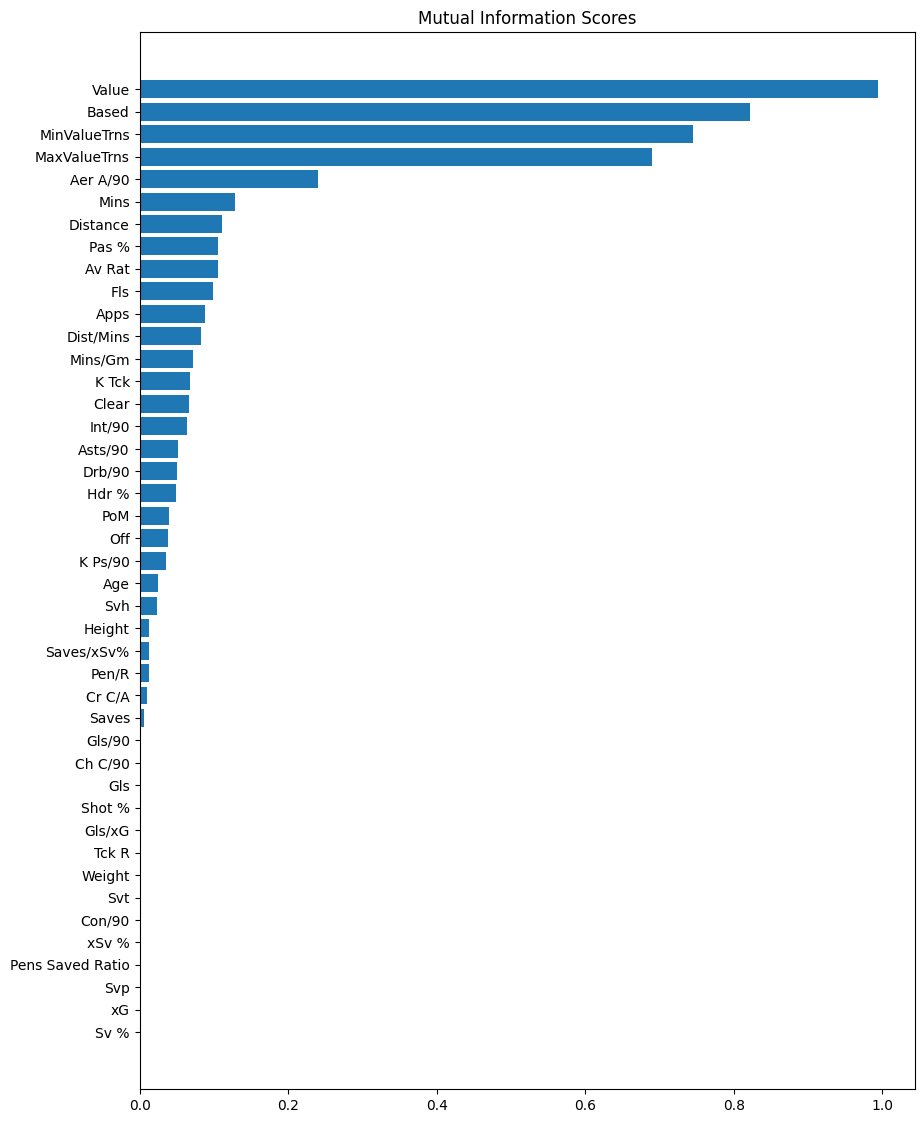

In [16]:
plt.figure(dpi=100, figsize=(10, 14))
plot_mi_scores(mi_scores)

Trovo un po' sospetto che il valore del giocatore e la lega in cui gioca impattino così tanto nella variabile target, così ho deciso di provare a standardizzare i valori, ma il risultato è lo stesso. Inoltre mi "puzza" il fatto che metriche come minuti giocati per partita e goal fatti per partita impattino così poco.

In [22]:
#X_train_tmp = X_train.copy()

#X_train_tmp["Based"] = (X_train_tmp["Based"] - X_train_tmp["Based"].mean()) / X_train_tmp["Based"].std()
#X_train_tmp["Value"] = (X_train_tmp["Value"] - X_train_tmp["Value"].mean()) / X_train_tmp["Value"].std()

#mi_scores_norm = calc_mi_scores(X_train_tmp, y_train, discrete_feature)
#plt.figure(dpi=100, figsize=(10, 14))
#plot_mi_scores(mi_scores_norm)

Tempo di creare il modello e addestrarlo

In [58]:
linear_regressor = LinearRegression()
random_forest_regressor = RandomForestRegressor()
xgb_regressor = xg.XGBRegressor()

In [ ]:
linear_score = cross_val_score(linear_regressor, X_train, y_train, cv=5, scoring="neg_mean_squared_log_error")
random_forest_score = cross_val_score(random_forest_regressor, X_train, y_train, cv=5, scoring="neg_mean_squared_log_error")
xgb_score = cross_val_score(xgb_regressor, X_train, y_train, cv=5, scoring="neg_mean_squared_log_error")

In [60]:
print(f"Lo score per il Linear è : {(-linear_score).mean()}")
print(f"Lo score per il Random Forest è : {(-random_forest_score).mean()}")
print(f"Lo score per XGB è : {(-xgb_score).mean()}")

Lo score per il Linear è : 0.005467791883645432
Lo score per il Random Forest è : 0.0036001604013994994
Lo score per XGB è : 0.0032347608349820784
